In [1]:
from util import *
%load_ext autoreload

In [ ]:
%autoreload

# Gaussian Clusters Example

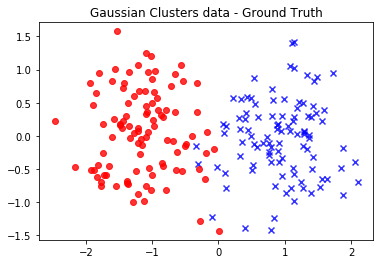

In [2]:
# Problem Setup --- Need to rework this example to be more general. I've made it so that the clusters are 
# in consecutive order for plotting m (0-99, 100-199). For this I had to re write the helper functions when 
# doing the Two moons dataset.

Ns = [100,100]
N = sum(Ns)
fs = 5
means = [np.array([1.0,0.]), np.array([-1.0,0.])]
Covs = [0.3*np.eye(2), 0.3*np.eye(2)]

# define fidelity and ground truth 
fid_orig = {}
fid_orig[1] = list(range(fs))
fid_orig[-1] = [Ns[0] + i for i in range(fs)]
ground_truth = np.array([1. if i<Ns[0] else -1. for i in range(N)])


# Graph computations
X, W = generate_data_graphs(Ns, means, Covs)
w,v = get_eig_Lnorm(W)

# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 20


# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.8)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.8)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

Iter = 0


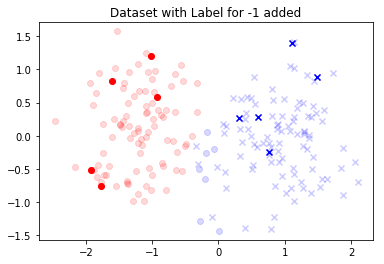

Time for EEM = 0.235491
Iter = 1


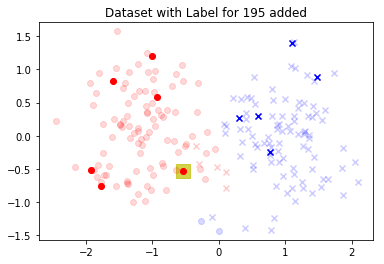

Time for EEM = 0.193929
Iter = 2


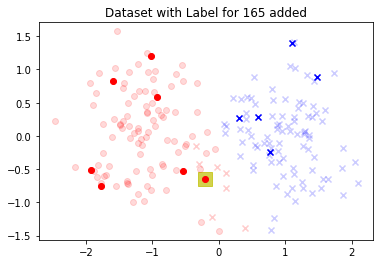

Time for EEM = 0.199312
Iter = 3


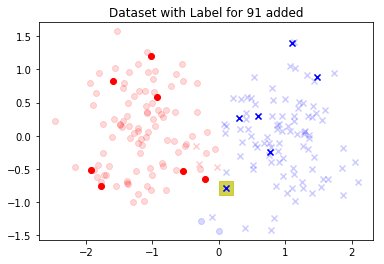

Time for EEM = 0.193738
Iter = 4


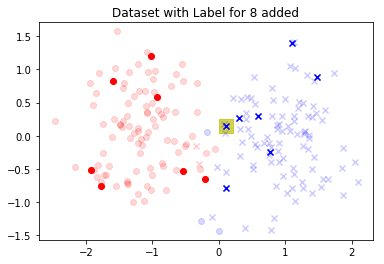

Time for EEM = 0.192581
Iter = 5


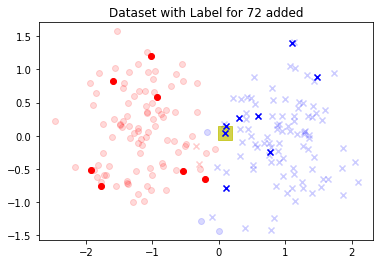

Time for EEM = 0.189758
Iter = 6


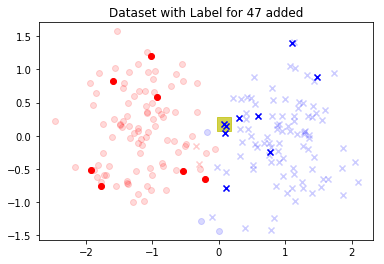

Time for EEM = 0.180641
Iter = 7


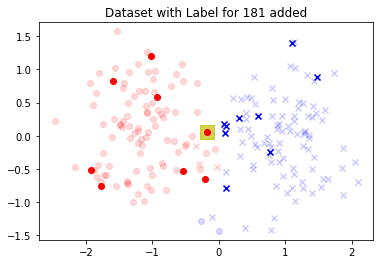

Time for EEM = 0.183870
Iter = 8


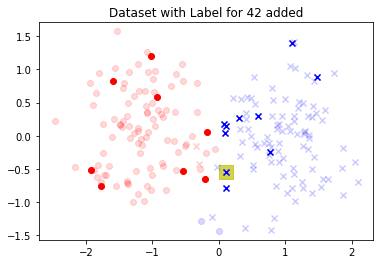

Time for EEM = 0.176806
Iter = 9


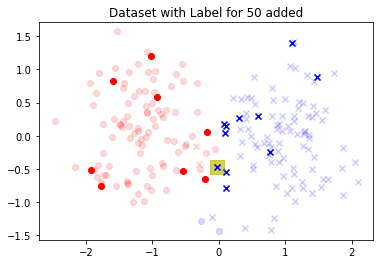

Time for EEM = 0.184760
Iter = 10


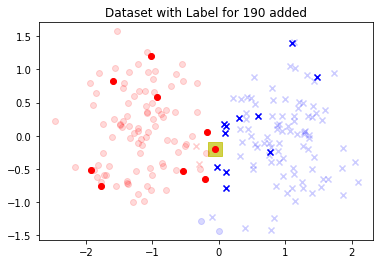

Time for EEM = 0.178203
Iter = 11


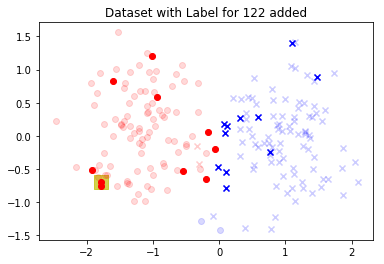

Time for EEM = 0.180843
Iter = 12


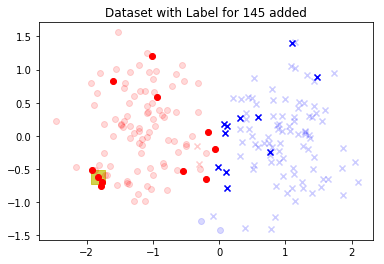

Time for EEM = 0.163582
Iter = 13


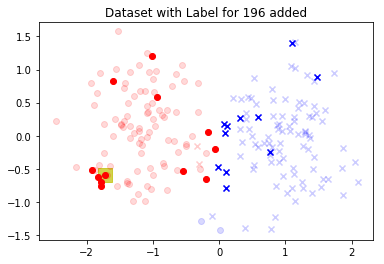

Time for EEM = 0.177614
Iter = 14


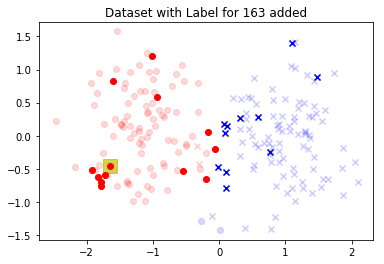

Time for EEM = 0.165055
Iter = 15


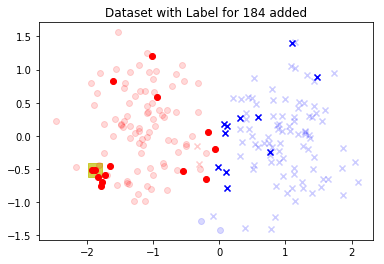

Time for EEM = 0.160154
Iter = 16


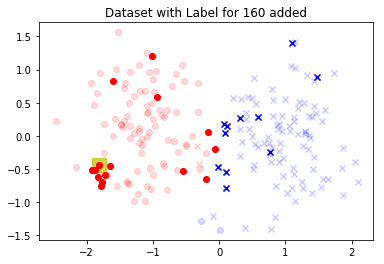

In [ ]:
# Active Learning
fid = copy.deepcopy(fid_orig)
tag2 = (tau, alpha, gamma2)
test_opts = (num_iters, True)
ERRS, M = run_test_AL(X, v, w, fid, ground_truth, tag2, test_opts)

if verbose:
    print(ERRS)

## Compare to Random Sampling

In [ ]:
fid = copy.deepcopy(fid_orig)
tag2 = (tau, alpha, gamma2)
test_opts = (num_iters, False)
ERRS_rand, M_rand = run_test_rand(X, v, w, fid, ground_truth, tag2, test_opts)

if verbose:
    print(ERRS_rand)

## Convergence Comparison

In [ ]:
ids_al, errs = zip(*ERRS)
ids_rand, errs_rand = zip(*ERRS_rand)
plt.plot(range(num_iters+1), errs, 'b--', label='AL')
plt.plot(range(num_iters+1), errs_rand, 'g', label='random')
plt.title('Convergence Plot')
plt.legend()
plt.show()

# Analyzing solution $\mathbf{m}$

In [ ]:
m = M[0]

lin = [i for i in range(N)]
print(m.shape)
print(len(lin))
plt.scatter(lin, list(m), marker='.')
plt.plot(lin, N*[0.], 'r--', linewidth=1.5)
plt.show()

In [ ]:
for l in range(5):
    if l % 3 == 0:
        m = list(M[l])
        lin = [i for i in range(N)]
        plt.scatter(lin, m, marker='.')
        plt.plot(lin, N*[0.], 'r--', linewidth=1.5)
        plt.title('Iter = %d' % l)
        plt.show()

In [ ]:
m = M[0]
m_new = m.copy()
m_new[m_new > 1.] = 1.
m_new[m_new < -1.] = -1.


In [ ]:
def E(x):
    vTx = v.T.dot(x.T)
    wvTx = np.diag(w).dot(vTx)
    val = vTx.T.dot(wvTx)
    return  val + (1./gamma**2)*np.linalg.norm(B.dot(x.T).flatten() - y)**2.

In [ ]:
B_diag = np.zeros(N)
labeled = set()
for k in fid_orig.keys():
    labeled = labeled.union(set(fid_orig[k]))
labeled = list(labeled)
B_diag[labeled] = 1.
B = sp.sparse.diags(B_diag, format='lil')
m, C, y = calc_orig(v, w, B, fid, tau, alpha, gamma2)

E_m = E(m)
E_m_new = E(m_new)

In [ ]:
print(E_m, E_m_new)

# 2 Moons Example


Functions in this section are defined in the ``util.py`` helper file with names like ``*2``, ``*2AL``, etc.

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
# Setup
N = 1000
data = make_moons(N, noise=0.15)

X, ground_truth = data
X1, X2 = X[ground_truth == 0,:], X[ground_truth == 1,:] 
ground_truth[np.where(ground_truth == 0)] = -1

#plt.rcParams['figure.figsize'] =(6,6)
plt.scatter(X1[:,0], X1[:,1], c='r')
plt.scatter(X2[:,0], X2[:,1], c='b')
plt.title('Two Moons dataset')
plt.show()



# Define the labeled and unlabed indices
sup_percent = 0.1
indices = np.array(list(range(N)))
labeled_orig = set()
fid_orig = {}
gt_flipped = {}
for i in [-1,1]:
    i_mask = indices[ground_truth ==i]
    gt_flipped[i] = i_mask
    np.random.shuffle(i_mask)
    n_i = len(i_mask)
    fid_orig[i] = list(i_mask[:int(sup_percent*n_i)])
    labeled_orig = labeled_orig.union(set(fid_orig[i]))
unlabeled_orig = sorted(list(set(indices) - labeled_orig))
labeled_orig = sorted(list(labeled_orig))


# Graph Generation and Eigen-Calculation
W = make_sim_graph(X)
w,v = get_eig_Lnorm(W)


# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 5

In [ ]:
# Active Learning Choices -- EEM 
fid = copy.deepcopy(fid_orig)
tag2 = (tau, alpha, gamma2)
test_opts = (num_iters, verbose)
ERRS, M = run_test_AL(X, v, w, fid, ground_truth, tag2, test_opts)

if verbose:
    print(ERRS)

In [ ]:
# Random choice
labeled = labeled_orig.copy()
unlabeled = unlabeled_orig.copy()
fid = copy.deepcopy(fid_orig)

ERRS_rand, M_rand = run_test_rand(X, v, w, fid, ground_truth, tag2, test_opts)
if verbose:
    print(ERRS_rand)

## Error Plotting - 2 Moons 

In [ ]:
colors = ['y', 'r', 'k', 'g']
ids, errs = zip(*ERRS)
ids_rand, errs_rand = zip(*ERRS_rand)
plt.figure()
plt.plot([i for i in range(num_iters+1)], errs, 'b--', label='AL')
plt.plot([i for i in range(num_iters+1)], errs_rand, 'g-o', label='rand')
test_opts = (num_iters, False)
for i in range(4):
    labeled = labeled_orig.copy()
    unlabeled = unlabeled_orig.copy()
    fid = copy.deepcopy(fid_orig)

    ERRS_rand, M_rand = run_test_rand(X, v, w, fid, ground_truth, tag2, test_opts)
    ids_rand, errs_rand = zip(*ERRS_rand)
    plt.plot([i for i in range(num_iters+1)], errs_rand,'%so-'%colors[i], label='rand')
plt.legend()


# Faster Approximations

We can calculate $\mathbf{m}|_u$ faster with using the derivation given in Rasmussen's Gaussian Process book. 

$$
    \mathbf{m}_u = C_\tau^{u \ell} \left( \gamma^2 I  + C_\tau^{\ell \ell}\right)^{-1}\mathbf{y}
$$

Where $C_\tau^{u \ell}, C_\tau^{\ell \ell}$ are the submatrices of $C_\tau = \tau^{2\alpha}(L + \tau^2 I)^{-alpha}$ corresponding to the ``unlabeled`` ($u$) and ``labeled`` ($\ell$) indices.

Could also do the matrix multiplication

$$ 
    \mathbf{m} = \begin{bmatrix}
                C_\tau^{\ell \ell} \\
                C_\tau^{u \ell} \\
                \end{bmatrix} \left( \gamma^2 I  + C_\tau^{\ell \ell}\right)^{-1}\mathbf{y}.
$$
to obtain $\mathbf{m}$ on all the indices.


In [ ]:
# Problem Setup --- Need to rework this example to be more general. I've made it so that the clusters are 
# in consecutive order for plotting m (0-99, 100-199). For this I had to re write the helper functions when 
# doing the Two moons dataset.

Ns = [1000,1000]
N = sum(Ns)
fs = 50
means = [np.array([1.0,0.]), np.array([-1.0,0.])]
Covs = [0.3*np.eye(2), 0.3*np.eye(2)]

# define fidelity and ground truth 
fid_orig = {}
fid_orig[1] = list(range(fs))
fid_orig[-1] = [Ns[0] + i for i in range(fs)]
ground_truth = np.array([1. if i<Ns[0] else -1. for i in range(N)])


# Graph computations
X, W = generate_data_graphs(Ns, means, Covs)
w,v = get_eig_Lnorm(W)

# Model Setup
tau, alpha, gamma = 0.001, 1.0, 0.0001
gamma2 = gamma**2.
verbose = True     # set to True if want to see visual of which points chosen
num_iters = 20


# Plot the data set
plt.rcParams['figure.figsize'] = (6,4)
plt.scatter(X[:Ns[0],0], X[:Ns[0],1], marker='x', c='b', alpha=0.8)
plt.scatter(X[Ns[0]:,0], X[Ns[0]:,1], marker='o', c='r',alpha=0.8)
plt.axis('equal')
plt.title('Gaussian Clusters data - Ground Truth')
plt.show()

In [ ]:
# Other Approximation for finding m restricted to the unlabeled set
labeled = set()
indices = np.array(list(range(N)))
for k in fid.keys():
    k_mask = indices[ground_truth ==k]
    gt_flipped[k] = k_mask
    labeled = labeled.union(set(fid[k]))
unlabeled = sorted(list(set(indices) - labeled))
labeled = sorted(list(labeled)) 

# Initial solution - find m and C, keep track of y
B_diag = np.zeros(N)
B_diag[labeled] = 1.
B = sp.sparse.diags(B_diag, format='lil')

m, C, y = calc_orig2(v, w, B, fid, tau, alpha, gamma2)

In [ ]:
# only m_u
tic = time.clock()
w_inv = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
v_lab = v[labeled,:]   # get the rows of v corresponding to labeled points
w_inv_v_lab = (v_lab*w_inv).T
C_ul = v[unlabeled,:].dot(w_inv_v_lab)
A = v_lab.dot(w_inv_v_lab)
A[np.diag_indices(N_prime)] += gamma2
A_inv = sla.inv(A)
m_u = C_ul.dot(A_inv.dot(y[labeled]))
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m_u, m[0,unlabeled]))

In [ ]:
# all of m
tic = time.clock()
w_inv = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
v_lab = v[labeled,:]   # get the rows of v corresponding to labeled points
#v_unlab = v[unlabeled,:]
w_inv_v_lab = (v_lab*w_inv).T
C_all_l = v.dot(w_inv_v_lab)
A = v_lab.dot(w_inv_v_lab)
A[np.diag_indices(N_prime)] += gamma2
A_inv = sla.inv(A)
m_all = C_all_l.dot(A_inv.dot(y[labeled]))
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m, m_all))

In [ ]:
# the calculation in the code currently
tic = time.clock()
d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
# prior_inv : C_{tau,eps}^{-1}, where
# C_{tau, eps}^{-1} = tau^{-2alpha}(L + tau^2 I)^alpha
prior_inv = v.dot(sp.sparse.diags([1./thing for thing in d], format='lil').dot(v.T))
# B/gamma^2
B_over_gamma2 = B / (gamma2)
# post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
post_inv  = prior_inv + B_over_gamma2
C = post_inv.I
m_comp = (1./gamma2)*C.dot(y).flatten()
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m_comp, m_all)) # check that it still calculates correctly...

## Observations 

This seems to scale much better than previous calculation. Now, we look to calculating $C$ as well, since that is needed for our sampling and future updating with t


Calculating $C$ then is found by just applying Woodbury identity on our normal expression for $C$:
$$
\begin{align}
    C &= \left(C_\tau^{-1} + \frac{1}{\gamma^2}B\right)^{-1} \\
    &= C_\tau - C_\tau H^T \left(\gamma^2 I + H C_\tau H^T \right)^{-1}HC_\tau \\
    &= C_\tau - C_\tau^{:,\ell}\left(\gamma^2 I + H C_\tau H^T \right)^{-1}C_\tau^{\ell, :} \\
\end{align}
$$

This is a little more costly than just the update to $\mathbf{m}$ because of the need to explicitly calculate $C_\tau$, but it's still faster I believe.

In [ ]:
# all of m and C...
tic = time.clock()
w_inv = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)     # diagonalization of C_t,e
C_tau = v.dot((v*w_inv).T)
C_ll = C_tau[np.ix_(labeled, labeled)]
C_all_l = C_tau[:,labeled]
C_ll[np.diag_indices(N_prime)] += gamma2  # directly changing C_ll
A_inv = sla.inv(C_ll)
Block1 = C_all_l.dot(A_inv)
C2 = C_tau - Block1.dot(C_all_l.T)
m_all2 = Block1.dot(y[labeled])
toc = time.clock()
print(toc - tic)

In [ ]:
print(np.allclose(m_all2, m))
print(np.allclose(C2, C))